Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Train Loss: 0.0067, Val Loss: 0.0028
Epoch 2/20, Train Loss: 0.0027, Val Loss: 0.0024
Epoch 3/20, Train Loss: 0.0024, Val Loss: 0.0022
Epoch 4/20, Train Loss: 0.0021, Val Loss: 0.0019
Epoch 5/20, Train Loss: 0.0019, Val Loss: 0.0020
Epoch 6/20, Train Loss: 0.0019, Val Loss: 0.0018
Epoch 7/20, Train Loss: 0.0019, Val Loss: 0.0018
Epoch 8/20, Train Loss: 0.0018, Val Loss: 0.0019
Epoch 9/20, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 10/20, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 11/20, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 12/20, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 13/20, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 14/20, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 15/20, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 16/20, Train Loss: 0.0018, Val Loss: 0.0017
Epoch 17/20, Train Loss: 0.0018, Val Loss: 0.0017
Epoch 18/20, Train Loss: 0.0018, Val Loss: 0.0017
Epoch 19/20, Train Loss: 0.0018, Val Loss: 0.0018
Epoch 20/20, Train Loss: 0.0018, Val Loss: 0.0017


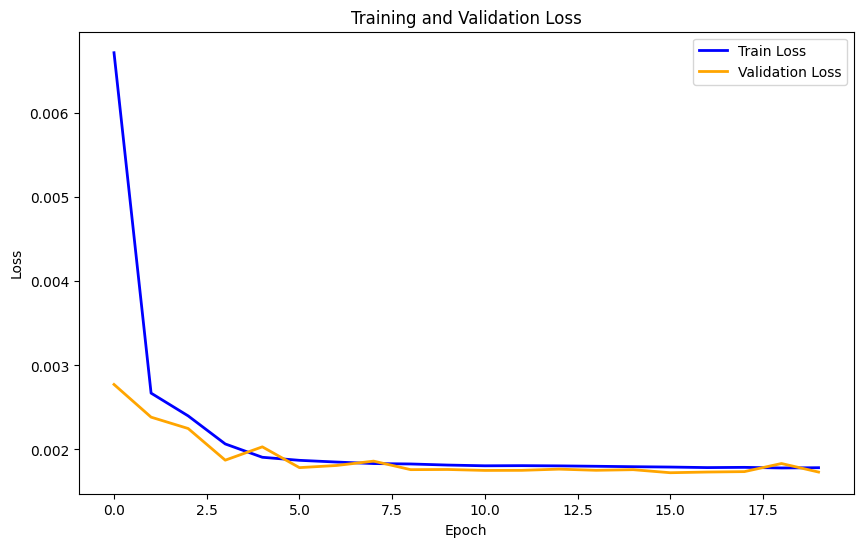

<ipython-input-4-cf492f870969>:162: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/lstm_transformer_best_model.pth'))

MSE: 3.8542
MAE: 1.4459
RMSE: 1.9632
MAPE (Filtered): 14.64%
Training Time: 415.01 seconds
Inference Time: 1.93 seconds


In [ ]:
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define LSTM-Transformer model
class LSTMTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, lstm_hidden_dim, num_heads, num_layers, output_length):
        super(LSTMTransformer, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, batch_first=True)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=0.1),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, output_length)
        self.embed = nn.Linear(lstm_hidden_dim, embed_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.embed(lstm_out)
        x = self.encoder(x.permute(1, 0, 2))
        x = x[-1]  # Use the last time step
        return self.fc(x)

# Load data
data = pd.read_excel('/content/drive/MyDrive/data_set/train/reversed_weather_data.xlsx', index_col=0)

# Target and features
target = data['temp'].values
features = data.values  # Use all columns as features

# Scale data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features = scaler_features.fit_transform(features)
target = scaler_target.fit_transform(target.reshape(-1, 1)).flatten()

# Hyperparameters
input_length = 24 * 7  # 1 week of hourly data
output_length = 24  # 1 day of hourly data
embed_dim = 128
lstm_hidden_dim = 64
num_heads = 4
num_layers = 2
batch_size = 32
learning_rate = 1e-4
epochs = 20
patience = 5

# Dataset class
class MultiFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features, target, input_length, output_length):
        self.features = features
        self.target = target
        self.input_length = input_length
        self.output_length = output_length

    def __len__(self):
        return len(self.target) - self.input_length - self.output_length + 1

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.input_length]
        y = self.target[idx + self.input_length:idx + self.input_length + self.output_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Dataset and DataLoader
dataset = MultiFeatureDataset(features, target, input_length, output_length)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = LSTMTransformer(
    input_dim=features.shape[1],
    embed_dim=embed_dim,
    lstm_hidden_dim=lstm_hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    output_length=output_length
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Training loop with early stopping
best_loss = float('inf')
stopping_counter = 0
train_losses, val_losses = [], []
training_start_time = time.time()

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        stopping_counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/lstm_transformer_best_model.pth')
    else:
        stopping_counter += 1
        if stopping_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

training_end_time = time.time()
training_duration = training_end_time - training_start_time

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Load best model
model.load_state_dict(torch.load('/content/drive/MyDrive/lstm_transformer_best_model.pth'))
model.eval()

# Evaluate model with test data
predictions, targets = [], []
inference_start_time = time.time()

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        predictions.append(preds.cpu().numpy())
        targets.append(y_batch.cpu().numpy())

inference_end_time = time.time()
inference_duration = inference_end_time - inference_start_time

# Flatten predictions and targets
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# Invert scaling
predictions = scaler_target.inverse_transform(predictions)
targets = scaler_target.inverse_transform(targets)

# Calculate metrics
mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)
rmse = np.sqrt(mse)

# Filter zero or near-zero target values
nonzero_targets = targets > 1e-3
filtered_predictions = predictions[nonzero_targets]
filtered_targets = targets[nonzero_targets]

# Calculate MAPE
mape = np.mean(np.abs((filtered_targets - filtered_predictions) / filtered_targets)) * 100

# Display metrics
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE (Filtered): {mape:.2f}%")
print(f"Training Time: {training_duration:.2f} seconds")
print(f"Inference Time: {inference_duration:.2f} seconds")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-5-4dfe93c8080f>:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

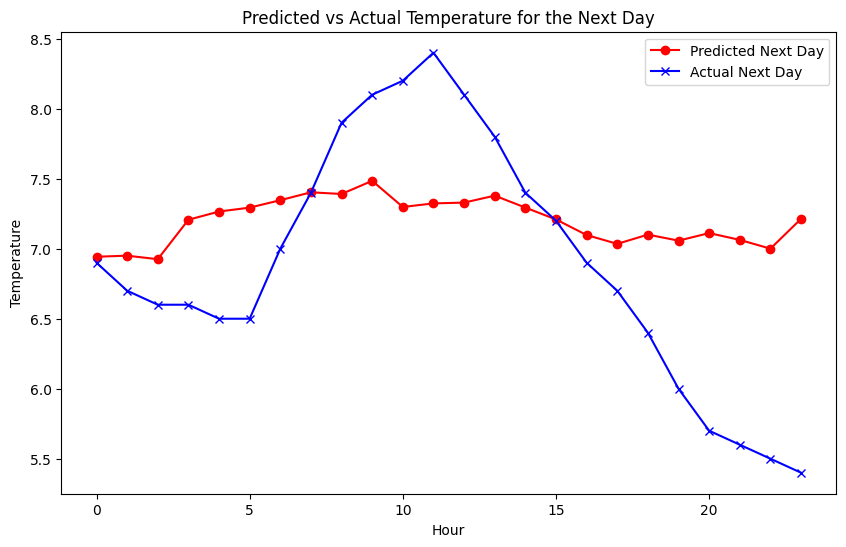

In [ ]:
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define LSTM-Transformer model
class LSTMTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, lstm_hidden_dim, num_heads, num_layers, output_length):
        super(LSTMTransformer, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, batch_first=True)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=0.1),
            num_layers=num_layers
        )
        self.fc = nn.Linear(embed_dim, output_length)
        self.embed = nn.Linear(lstm_hidden_dim, embed_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.embed(lstm_out)
        x = self.encoder(x.permute(1, 0, 2))
        x = x[-1]  # Use the last time step
        return self.fc(x)

# Load best model
model = LSTMTransformer(
    input_dim=6,  # Including temp, dwpt, rhum, wdir, wspd, pres
    embed_dim=128,
    lstm_hidden_dim=64,
    num_heads=4,
    num_layers=2,
    output_length=24
).to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/lstm_transformer_best_model.pth'))
model.eval()

# Load data
data = pd.read_excel('/content/drive/MyDrive/data_set/train/reversed_weather_data.xlsx', index_col=0)

# Target and features
target = data['temp'].values
features = data.values  # Use all columns as features

# Scale data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features = scaler_features.fit_transform(features)
target = scaler_target.fit_transform(target.reshape(-1, 1)).flatten()

# Select last week for prediction
input_length = 24 * 7  # 1 week of hourly data
output_length = 24  # 1 day of hourly data

last_week_features = features[-(input_length + output_length):-output_length]
real_next_day = target[-output_length:]

# Convert to tensors
last_week_features_tensor = torch.tensor(last_week_features, dtype=torch.float32).unsqueeze(0).to(device)

# Perform prediction
with torch.no_grad():
    predicted_next_day = model(last_week_features_tensor).cpu().numpy().flatten()

# Invert scaling
predicted_next_day = scaler_target.inverse_transform(predicted_next_day.reshape(-1, 1)).flatten()
real_next_day = scaler_target.inverse_transform(real_next_day.reshape(-1, 1)).flatten()

# Plot comparison of prediction and actual data
plt.figure(figsize=(10, 6))
plt.plot(predicted_next_day, label='Predicted Next Day', color='red', marker='o')
plt.plot(real_next_day, label='Actual Next Day', color='blue', marker='x')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.title('Predicted vs Actual Temperature for the Next Day')
plt.legend()
plt.show()

Rapor: LSTM-Transformer Tabanlı Hava Durumu Tahmin Modeli
Giriş

Bu çalışmada, LSTM-Transformer tabanlı bir model, hava durumu verilerinden faydalanarak kısa vadeli sıcaklık tahmini yapmak üzere eğitilmiştir. Eğitim ve değerlendirme süreçleri PyTorch kütüphanesi ile yürütülmüş ve modelin performansı çeşitli metriklerle analiz edilmiştir.
Kullanılan Teknoloji ve Model

LSTM-Transformer modeli, hem zaman serisi verilerindeki ardışık bağımlılıkları hem de uzun vadeli ilişkileri modellemek için geliştirilmiştir. LSTM katmanı, giriş verilerindeki ardışık bağımlılıkları öğrenirken; Transformer Encoder katmanı, veriler arasındaki uzun vadeli ilişkileri öğrenmek için kullanılmıştır. Modelin diğer özellikleri:

    Girdi Özellikleri: Sıcaklık (temp), çiy noktası (dwpt), bağıl nem (rhum), rüzgar yönü (wdir), rüzgar hızı (wspd), basınç (pres)
    Girdi Uzunluğu: 7 günlük saatlik veri (24 * 7)
    Çıktı Uzunluğu: 24 saatlik tahmin

Eğitim Süreci

    Eğitim Hiperparametreleri:
        Embed Boyutu: 128
        LSTM Gizli Boyutu: 64
        Transformer Katman Sayısı: 2
        Bağlantı Başlığı Sayısı (Heads): 4
        Öğrenme Oranı: 1e-4
        Batch Boyutu: 32
        Erken Durdurma Eşiği: 5 epoch
    Eğitim Süresi: 415.01 saniye
    Eğitim ve Doğrulama Kayıp Eğrisi: Eğitim ve doğrulama kaybı grafiği, modelin hızla öğrenip stabil hale geldiğini göstermektedir.

Performans Metrikleri

Modelin performansı aşağıdaki metriklerle değerlendirildi:

    MSE (Ortalama Kare Hata): 3.8542
    MAE (Ortalama Mutlak Hata): 1.4459
    RMSE (Kök Ortalama Kare Hata): 1.9632
    MAPE (Ortalama Yüzde Hata - Filtrelenmiş): %14.64

MAPE değerinin düşük olması, modelin sıcaklık tahmininde yüksek doğruluk sunduğunu göstermektedir.
Tahmin Analizi

Model, test verilerinden son bir hafta boyunca gözlemlenen verilere dayanarak 24 saatlik sıcaklık tahmini yapmıştır. Tahmin sonuçları, gerçek değerlerle karşılaştırılmıştır. Tahmin ve gerçek veriler arasındaki benzerlik, modelin başarılı bir şekilde genelleme yapabildiğini göstermektedir.
Tahmin ve Gerçek Değerler Grafiği:

Grafik, modelin gerçek sıcaklık değişimlerini tahmin etmekte genel olarak başarılı olduğunu göstermiştir. Ancak, bazı saatlerde küçük sapmalar gözlemlenmiştir.
Sonuç ve İyileştirme Önerileri

    Sonuç: LSTM-Transformer tabanlı model, kısa vadeli hava durumu tahmininde etkili sonuçlar sağlamıştır. Düşük MAPE değeri, modelin yüksek doğruluğunu desteklemektedir.
    İyileştirme Önerileri:
        Daha Fazla Veri: Modelin daha geniş bir veri setiyle eğitilmesi, genelleme yeteneğini artırabilir.
        Hiperparametre Optimizasyonu: Öğrenme oranı, gizli katman boyutları gibi parametrelerde optimizasyon yapılarak performans artırılabilir.
        Ek Özellikler: Güneş ışınımı, yağış miktarı gibi ek çevresel verilerin dahil edilmesi tahmin doğruluğunu artırabilir.

Bu model, hava durumu tahmininde kullanılabilecek başarılı bir temel oluşturmaktadır. Ancak, veri zenginliği ve model optimizasyonu ile performans daha da artırılabilir.